## Submit

In [64]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [78]:
from google.colab import drive
drive.mount('/content/drive/')
df=pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
df.head()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,ID,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,date_of_registration
0,0,ecom,73749.0,20167.0,24000,2509,166,800,3.408171,2021-09-08 06:28:32.157046464
1,1,information_source,1814015.0,321069.0,0,0,0,739,7.613713,2024-07-04 23:36:39.276336238
2,2,ecom,11352870.0,5377369.0,7807118,202610,71386,16214,7.747694,2024-02-26 11:39:21.926781108
3,3,ecom,1811896.0,0.0,1340025,11674,0,0,2.882191,2023-11-03 23:52:15.085026428
4,4,ecom,2068968.0,999279.0,187409,45723,7666,3520,8.618482,2023-07-11 11:55:16.739515152


Прежде чем начать построение модели обработаем пропуски данных:

 * Пропуски в числовых колонках, а именно clicks, likes, buys, 4xx_errors,5xx_errors, заполним медианными значениями
 * В столбце complaints_count были встречены дефисы, заменим их на NaN и аналогично заполним медианными значениями
 * Пропуски в category заменим на значение 'unknown', чтобы сохранить целостность категориальных данных


In [66]:
df.fillna({'clicks': df['clicks'].median()}, inplace=True)
df.fillna({'likes': df['likes'].median()}, inplace=True)
df.fillna({'buys': df['buys'].median()}, inplace=True)
df.fillna({'4xx_errors': df['4xx_errors'].median()}, inplace=True)
df.fillna({'5xx_errors': df['5xx_errors'].median()}, inplace=True)
df['complaints_count'] = df['complaints_count'].replace('-', np.nan).astype('float64')
df.fillna({'complaints_count': df['complaints_count'].median()}, inplace=True)
df.fillna({'average_dwelltime': df['average_dwelltime'].median()}, inplace=True)
df.fillna({'category': 'unknown'}, inplace=True)

Построим начальные графики зависимостей для каждого параметра, сгруппировав данные по категориям

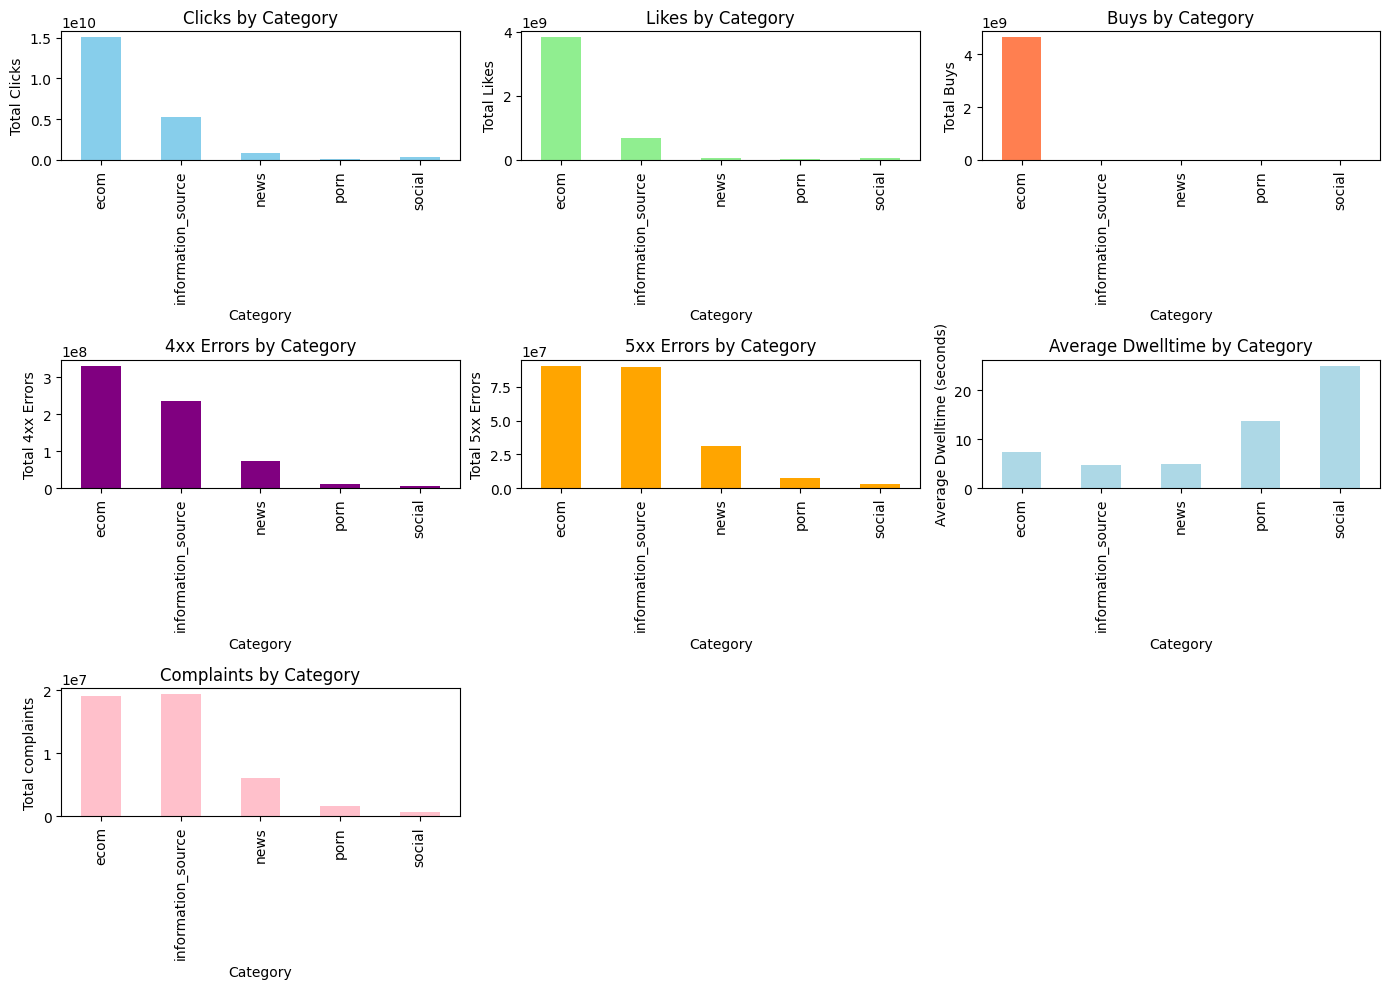

In [67]:
import pandas as pd
import matplotlib.pyplot as plt

clicks_cat = df.groupby('category')['clicks'].sum()
likes_cat = df.groupby('category')['likes'].sum()
buys_cat = df.groupby('category')['buys'].sum()
errors_4xx_cat = df.groupby('category')['4xx_errors'].sum()
errors_5xx_cat = df.groupby('category')['5xx_errors'].sum()
complaints_cat = df.groupby('category')['complaints_count'].sum()
dwelltime_cat = df.groupby('category')['average_dwelltime'].mean()

plt.figure(figsize=(14, 10))

plt.subplot(3, 3, 1)
clicks_cat.plot(kind='bar', color='skyblue')
plt.title('Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Total Clicks')

plt.subplot(3, 3, 2)
likes_cat.plot(kind='bar', color='lightgreen')
plt.title('Likes by Category')
plt.xlabel('Category')
plt.ylabel('Total Likes')

plt.subplot(3, 3, 3)
buys_cat.plot(kind='bar', color='coral')
plt.title('Buys by Category')
plt.xlabel('Category')
plt.ylabel('Total Buys')

plt.subplot(3, 3, 4)
errors_4xx_cat.plot(kind='bar', color='purple')
plt.title('4xx Errors by Category')
plt.xlabel('Category')
plt.ylabel('Total 4xx Errors')

plt.subplot(3, 3, 5)
errors_5xx_cat.plot(kind='bar', color='orange')
plt.title('5xx Errors by Category')
plt.xlabel('Category')
plt.ylabel('Total 5xx Errors')

plt.subplot(3, 3, 6)
dwelltime_cat.plot(kind='bar', color='lightblue')
plt.title('Average Dwelltime by Category')
plt.xlabel('Category')
plt.ylabel('Average Dwelltime (seconds)')

plt.subplot(3, 3, 7)
complaints_cat.plot(kind='bar', color='pink')
plt.title('Complaints by Category')
plt.xlabel('Category')
plt.ylabel('Total complaints')

plt.tight_layout()
plt.show()

Приступаем к созданию новых признаков. Для удобства преобразуем дату регистрации в  возраст домена. Затем создадим новые фичи для улучшения качества модели:
 * likes_to_clicks: отношение лайков к кликам
 * buys_to_clicks: отношение покупок к кликам
 * complaints_to_buys: отношение жалоб к покупкам
 * total_errors: общее количество ошибок за последние 6 месяцев (4xx + 5xx)
 * Логарифмирование некоторых переменных, таких как клики, лайки и покупки, что в итоге позволило уменьшить влияние выбросов, сгладив распределение значений

А также применим к категориальным признакам One-Hot Encoding


In [68]:
df['date_of_registration'] = pd.to_datetime(df['date_of_registration'], errors='coerce')
current_year = pd.Timestamp.now().year
df['domain_age'] = current_year - df['date_of_registration'].dt.year
df.fillna({'domain_age': df['domain_age'].median()}, inplace=True)

df['likes_to_clicks'] = df['likes'] / (df['clicks'] + 1)
df['buys_to_clicks'] = df['buys'] / (df['clicks'] + 1)
df['complaints_to_buys'] = df['complaints_count'] / (df['buys'] + 1)

df['total_errors'] = df['4xx_errors'] + df['5xx_errors']

df['log_clicks'] = np.log1p(df['clicks'])
df['log_likes'] = np.log1p(df['likes'])
df['log_buys'] = np.log1p(df['buys'])

df['errors_to_clicks'] = df['total_errors'] / (df['clicks'] + 1)

df_new = pd.get_dummies(df, columns=['category'], drop_first=True)

df_new.drop(columns=['date_of_registration'], inplace=True)

Построим графики для новых признаков

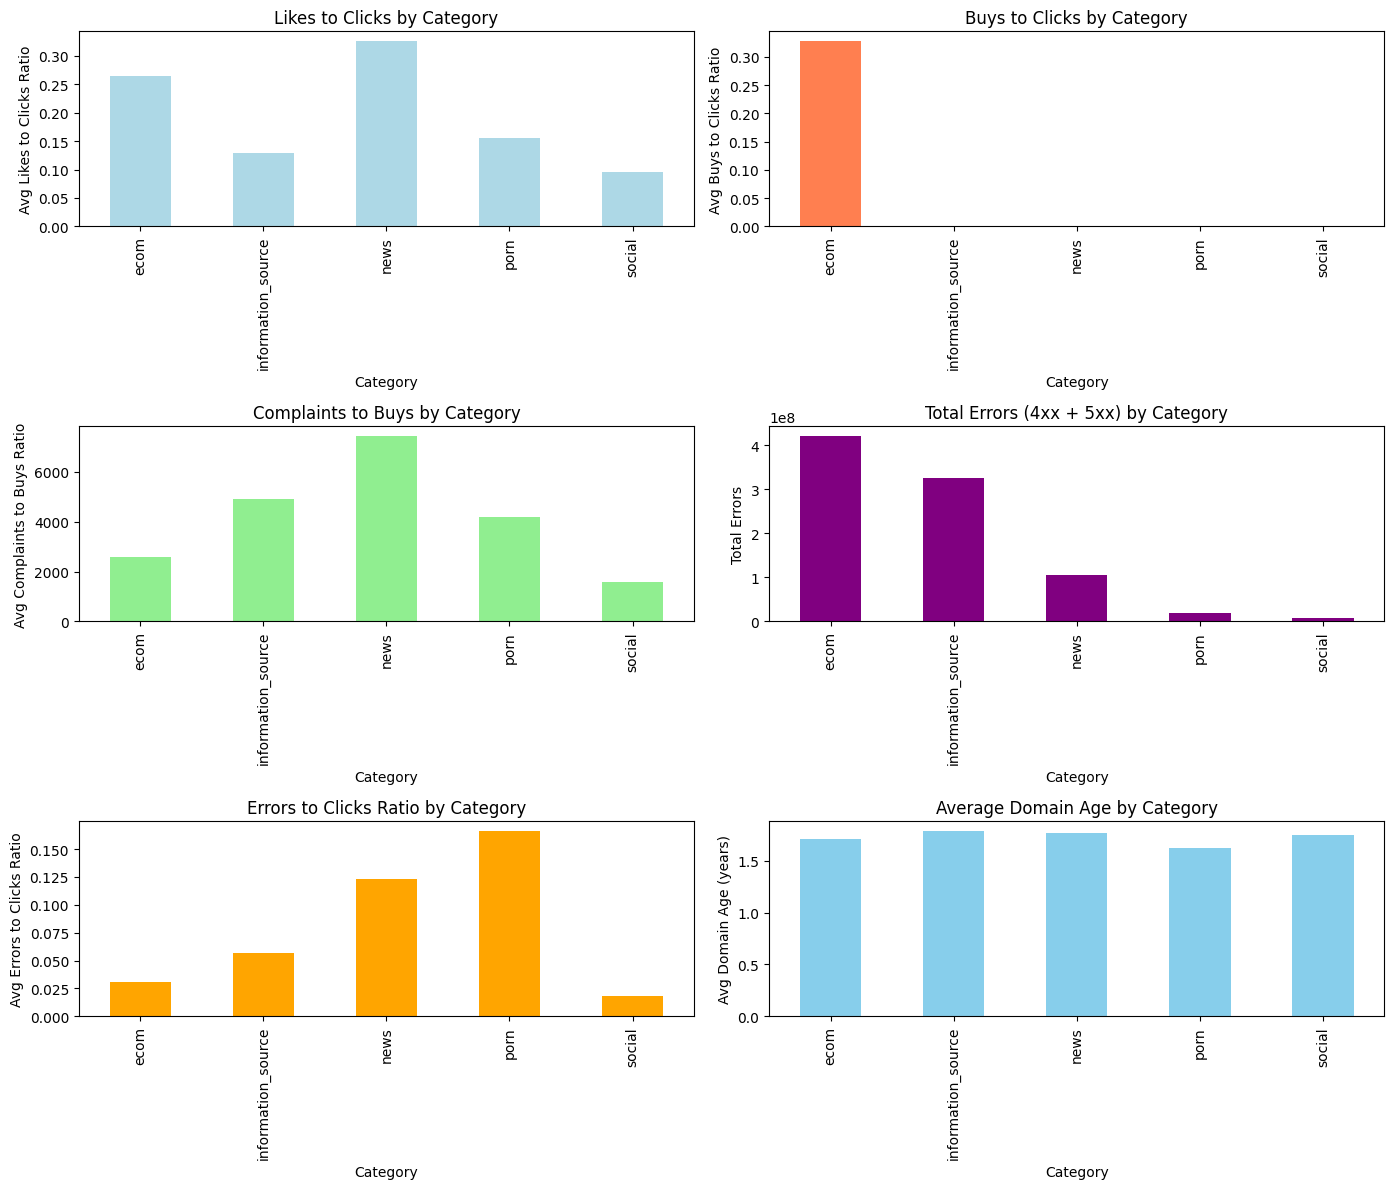

In [69]:
likes_to_clicks_cat = df.groupby('category')['likes_to_clicks'].mean()
buys_to_clicks_cat = df.groupby('category')['buys_to_clicks'].mean()
complaints_to_buys_cat = df.groupby('category')['complaints_to_buys'].mean()
total_errors_cat = df.groupby('category')['total_errors'].sum()
errors_to_clicks_cat = df.groupby('category')['errors_to_clicks'].mean()
domain_age_cat = df.groupby('category')['domain_age'].mean()

plt.figure(figsize=(14, 12))

plt.subplot(3, 2, 1)
likes_to_clicks_cat.plot(kind='bar', color='lightblue')
plt.title('Likes to Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Avg Likes to Clicks Ratio')

plt.subplot(3, 2, 2)
buys_to_clicks_cat.plot(kind='bar', color='coral')
plt.title('Buys to Clicks by Category')
plt.xlabel('Category')
plt.ylabel('Avg Buys to Clicks Ratio')

plt.subplot(3, 2, 3)
complaints_to_buys_cat.plot(kind='bar', color='lightgreen')
plt.title('Complaints to Buys by Category')
plt.xlabel('Category')
plt.ylabel('Avg Complaints to Buys Ratio')

plt.subplot(3, 2, 4)
total_errors_cat.plot(kind='bar', color='purple')
plt.title('Total Errors (4xx + 5xx) by Category')
plt.xlabel('Category')
plt.ylabel('Total Errors')

plt.subplot(3, 2, 5)
errors_to_clicks_cat.plot(kind='bar', color='orange')
plt.title('Errors to Clicks Ratio by Category')
plt.xlabel('Category')
plt.ylabel('Avg Errors to Clicks Ratio')

plt.subplot(3, 2, 6)
domain_age_cat.plot(kind='bar', color='skyblue')
plt.title('Average Domain Age by Category')
plt.xlabel('Category')
plt.ylabel('Avg Domain Age (years)')

plt.tight_layout()
plt.show()


На завершающем этапе сделаем разбиение данных на признаки и целевую переменную.
Для предсказания привлекательности используем линейную регрессию.
Данные разделим на обучающую и тестовую выборки (80%/20%).
Для оценки точности модели используем метрику Mean Squared Error (MSE), которая покажет, насколько хорошо модель предсказывает значение привлекательности на тестовых данных.

In [70]:
X = df_new.drop(columns=['source_attractiveness'])
y = df_new['source_attractiveness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.011983326365635129


In [79]:
test=pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")

test.fillna({'clicks': test['clicks'].median()}, inplace=True)
test.fillna({'likes': test['likes'].median()}, inplace=True)
test.fillna({'buys': test['buys'].median()}, inplace=True)
test.fillna({'4xx_errors': test['4xx_errors'].median()}, inplace=True)
test.fillna({'5xx_errors': test['5xx_errors'].median()}, inplace=True)
test['complaints_count'] = test['complaints_count'].replace('-', np.nan).astype('float64')
test.fillna({'complaints_count': test['complaints_count'].median()}, inplace=True)
test.fillna({'average_dwelltime': test['average_dwelltime'].median()}, inplace=True)
test.fillna({'category': 'unknown'}, inplace=True)

test['date_of_registration'] = pd.to_datetime(test['date_of_registration'], errors='coerce')
current_year = pd.Timestamp.now().year
test['domain_age'] = current_year - test['date_of_registration'].dt.year
test.fillna({'domain_age': test['domain_age'].median()}, inplace=True)

test['likes_to_clicks'] = test['likes'] / (test['clicks'] + 1)
test['buys_to_clicks'] = test['buys'] / (test['clicks'] + 1)
test['complaints_to_buys'] = test['complaints_count'] / (test['buys'] + 1)

test['total_errors'] = test['4xx_errors'] + test['5xx_errors']

test['log_clicks'] = np.log1p(test['clicks'])
test['log_likes'] = np.log1p(test['likes'])
test['log_buys'] = np.log1p(test['buys'])

test['errors_to_clicks'] = test['total_errors'] / (test['clicks'] + 1)

test = pd.get_dummies(test, columns=['category'], drop_first=True)

test.drop(columns=['date_of_registration'], inplace=True)

In [81]:
test = test.rename(columns={'ID': 'Unnamed: 0'})

In [82]:
y_pred_new = model.predict(test)

In [83]:
data = {
    "source_attractiveness": y_pred_new
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")